The first three cells are a copy of the DarkPhoton.py files included in the DarkCapPy package.
I have changed the relative path to the configuration files (constants.py, atomicData.py, etc..), and some of the relative paths within those files so that it would work from this notebook, without having to install the package.

Somehow, the computing time for the kappa_0 function is excessively long when importing the package into jupyter notebook on my end. Running the code directly from the notebook makes computing time acceptable (about 2-3 minutes vs an hour). There might be an issue in multiple imports of the package within the configuration files that needs to be looked at in the original package.

In [ ]:
################################################################
# Import Python Libraries
################################################################
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from Configure.Constants  import *
from Configure.AtomicData import *
from Configure.PlanetData  import *
from Configure.Conversions import amu2GeV

In [3]:

# import os                                          | Reference: https://stackoverflow.com/questions/779495/python-access-data-in-package-subdirectory
# this_dir, this_filename = os.path.split(__file__)  | This was a hack for importing the branching ratio inside of this file. 
# DATA_PATH = os.path.join(this_dir, "brtoe.csv")    | It is not presently needed, but may be useful in the future. 



################################################################
# Capture Rate Functions
################################################################


########################
# Nuclear Form Factor
########################
def formFactor2(element, E):
    '''
    formFactor2(element,E)

    Returns the form-factor squared of element N with recoil energy E
    [E] = GeV
    '''
    E_N = 0.114/((atomicNumbers[element])**(5./3))
    FN2 = np.exp(-E/E_N)
    return FN2

########################
# Photon Scattering Cross Sections
########################
def crossSection(element, m_A, E_R): # returns 1/GeV^3
	'''
	crossSection(element, m_A, E_R)
    
    Returns the differntial scattering cross section for a massive dark photon

    [m_A] = GeV
    [E_R] = GeV
    '''

	m_N = amu2GeV(atomicNumbers[element])
	FN2 = formFactor2(element, E_R)
	function = ( FN2 ) / ((2 * m_N * E_R + m_A**2)**2)
	return function

def crossSectionKappa0(element, E_R): # Dimensionless
	'''
	crossSectionKappa0(element, E_R)

	Returns the cross section used in the kappa0 calculation

	[E_R] = GeV
	'''

	FN2 = formFactor2(element, E_R)
	function = FN2
	return function



########################
# Kinematics
########################
def eMin(u, m_X):
	'''
	eMin(u, m_X)

	Returns the minimum kinetic energy to become Gravitationally captured by Earth

	[m_X] = GeV
	'''

	function = (0.5) * m_X * u**2
#     assert (function >=0), '(u, m_X): (%e,%e) result in a negative eMin' % (u, m_X)
	return function

def eMax(element, m_X, rIndex, u):
	'''
	eMax(element, m_X, rIndex, u)

	Returns the maximum kinetic energy allowed by the kinematics

	[m_X] = GeV

	rIndex specifies the index in the escape velocity array escVel2_List[rIndex]
	'''

	m_N = amu2GeV(atomicNumbers[element])
	mu = m_N*m_X / (m_N + m_X)
	vCross2 = (escVel2_List[rIndex])
	function = 2 * mu**2 * (u**2 + vCross2) / m_N
#     assert (function >= 0), '(element, m_X, rIndex, u): (%s, %e, %i, %e) result in negative eMax' %(element, m_X, rIndex, u)
	return function




########################
# Intersection Velocity
########################
def EminEmaxIntersection(element, m_X, rIndex):
	'''
	EminEmaxIntersection(element, m_X, rIndex):

	Returns the velocity uInt when eMin = eMax.

	[m_X] = GeV

	'''
	m_N = amu2GeV(atomicNumbers[element])
	mu = (m_N*m_X)/(m_N+m_X)

	sqrtvCross2 = np.sqrt(escVel2_List[rIndex])
	# Calculate the intersection uInt of eMin and eMax given a specific rIndex
	A = m_X/2. 
	B = 2. * mu**2 / m_N
	uInt = np.sqrt( ( B ) / (A-B) ) * sqrtvCross2

	return uInt




########################
# Photon Velocity and Energy Integration
########################
def intDuDEr(element, m_X, m_A, rIndex):
	'''
	intDuDER(element, m_X, m_A, rIndex):

	Returns the evaluated velocity and recoil energy integrals for dark photon scattering

	[m_X] = GeV
	[m_A] = GeV
	'''
    
	def integrand(E,u):
		fu = fCrossInterp(u)
		integrand = crossSection(element, m_A, E) * u * fu

		return integrand

	# Calculate the intersection uInt of eMin and eMax given a specific rIndex
	uInt = EminEmaxIntersection(element, m_X, rIndex)

	uLow = 0
	uHigh = min(uInt, V_gal) # We take the minimal value between the intersection velocity and galactic escape velocity
	eLow = lambda u: eMin(u, m_X)
	eHigh = lambda u: eMax(element, m_X, rIndex, u)
	integral = integrate.dblquad(integrand, uLow, uHigh, eLow, eHigh)[0]
	return integral




def intDuDErKappa0(element, m_X, rIndex):
	'''
	intDuDErKappa0(element, m_X, rIndex):

	returns the evaluated velocity and recoil energy integration for dark photon scattering 
		used in the kappa0 calculation

	[m_X] = GeV

	'''

	def integrand(E_R,u):
		fu = fCrossInterp(u)
		integrand = crossSectionKappa0(element, E_R) * u * fu
		return integrand

	uInt = EminEmaxIntersection(element, m_X, rIndex)

	uLow = 0
	uHigh = min(uInt, V_gal) # We take the minimal value between the intersection velocity and galactic escape velocity
	eLow = lambda u: eMin(u, m_X)
	eHigh = lambda u: eMax(element, m_X, rIndex, u)
	integral = integrate.dblquad(integrand, uLow, uHigh, eLow, eHigh)[0]
	return integral


########################
# Sum Over Radii
########################
def sumOverR(element, m_X, m_A):
	'''
	sumOverR(element, m_X, m_A)

	Returns the summation over radius of the velocity and recoil energy integration

	[m_X] = GeV
	[m_A] = GeV
	'''

	tempSum = 0
    
	for i in range(0, len(radius_List)):
		r = radius_List[i]
		deltaR = deltaR_List[i]

		n_N = numDensity_Func(element)[i]

		summand = n_N * r**2 * intDuDEr(element, m_X, m_A, i) * deltaR
		tempSum += summand
	return tempSum



def sumOverRKappa0(element, m_X):
	'''
	sumOverRKappa0(element, m_X)

	Returns the summation over radius of the velocity and recoil energy integration
		used in the kappa0 calculation

	[m_X] = GeV
	'''
	tempSum = 0
    
	for i in range(0,len(radius_List)):
		r = radius_List[i]
		deltaR = deltaR_List[i]

		n_N = numDensity_Func(element)[i]
		
		summand = n_N * r**2 * intDuDErKappa0(element, m_X, i) * deltaR
		tempSum += summand
	return tempSum


########################
# Single Element Capture Rate
########################
def singleElementCap(element, m_X, m_A, epsilon, alpha, alpha_X):
	'''
	singleElementCap(element, m_X, m_A, epsilon, alpha, alpha_X)

	Returns the capture rate due to a single element for the specified parameters

	[m_X] = GeV
	[m_A] = GeV
	'''
	Z_N = nProtons[element]
	m_N = amu2GeV(atomicNumbers[element])
	n_X = 0.3/m_X # GeV/cm^3

	conversion = (5.06e13)**-3 * (1.52e24) # Conversion to seconds (cm^-3)(GeV^-2) -> (s^-1)
	prefactors = (4*np.pi)**2
	crossSectionFactors = 2 * (4*np.pi) * epsilon**2 * alpha_X * alpha * Z_N**2 * m_N
	function = n_X * conversion* crossSectionFactors* prefactors * sumOverR(element, m_X, m_A)
	return function

def singleElementCapKappa0(element, m_X, alpha):
	'''
	singleElementCapKappa0(element, m_X, alpha):

	Returns a single kappa0 value for 'element' and the specified parameters

	[m_X] = GeV
	'''
	Z_N = nProtons[element]
	m_N = amu2GeV(atomicNumbers[element])
	n_X = 0.3/m_X # 1/cm^3

	conversion = (5.06e13)**-3 * (1.52e24) # (cm^-3)(GeV^-2) -> (s^-1)
	crossSectionFactors = 2 * (4*np.pi) * alpha * Z_N**2 * m_N

	prefactor = (4*np.pi)**2 

	function = n_X * conversion * prefactor * crossSectionFactors * sumOverRKappa0(element, m_X)
	return function




########################
# Full Capture Rate
########################
def cCap(m_X, m_A, epsilon, alpha, alpha_X):
	'''
	cCap(m_X, m_A, epsilon, alpha, alpha_X)

	returns the full capture rate in sec^-1 for the specified parameters

	Note: This function is the less efficient way to perform this calculation. Every point in (m_A, epsilon) space 
		involves peforming the full tripple integral over recoil energy, incident DM velocity, and Earth radius
		which is time consuming.

	[m_X] = GeV
	[m_A] = GeV
	'''
	totalCap = 0
	for element in element_List:
		elementCap = singleElementCap(element, m_X, m_A, epsilon, alpha, alpha_X)
		print ('Element:', element,',' 'Cap: ', elementCap)
		totalCap += elementCap 
	return totalCap



########################
# Kappa0
########################
def kappa_0(m_X, alpha):  
	'''
	kappa_0(m_X, alpha)

	Returns the kappa0 value for m_X and alpha

	[m_X] = GeV

	This funciton encodes how the capture rate depends on m_X and alpha.
	'''
	tempSum = 0 # tempSum = "temporary sum" not "temperature sum"
	for element in element_List:
		function = singleElementCapKappa0(element, m_X, alpha)
		tempSum += function

	return tempSum

########################
# Capture Rate the quick way
########################
def cCapQuick(m_X, m_A, epsilon, alpha_X, kappa0):
	'''
	cCapQuick(m_X, m_A, epsilon, alpha_X, kappa0): 

	Returns the Capture rate in a much more computationally efficient way. For a given dark matter mass m_X and coupling
		constant alpha, we calculate the quantity kappa_0 once and multiply it by the differential cross section approximation
		for each point in (m_A, epsilon) space. 


	[m_X] = GeV 
	[m_A] = GeV

	Provides a quick way to calculate the capture rate when only m_A and epsilon are changing.

	All the m_X dependence, which is assumed to be fixed, is contianed in kappa0. 
	Note that m_X is defined as an input to this function, but not actually used. 
		This was made in light of keeping the function definitions in Python consistent.
	'''
	function = epsilon**2 * alpha_X * kappa0 / m_A**4
	return function



################################################################
# Thermal Relic
################################################################
def alphaTherm(m_X, m_A):
    '''
    alphaTherm(m_X,m_A)

    [m_X] = GeV
    [m_A] = GeV
    
    This function determines the dark matter fine structure constant alpha_X given the dark matter relic abundance.
    '''

    conversion = (5.06e13)**3/ (1.52e24) # cm^3 Sec -> GeV^-2
    thermAvgSigmaV = 2.2e-26 # cm^3/s from ArXiV: 1602.01465v3 between eqns (4) and (5)
    
    function = conversion * thermAvgSigmaV * (m_X**2/np.pi) \
    * (1 - 0.5*(m_A/m_X)**2)**2 / ((1 - (m_A/m_X)**2)**(3./2))
    return np.sqrt(function)

# Thermal Relic for m_X >> m_A Approximation
def alphaThermApprox(m_X):
    '''
    alphaThermApprox(m_X)
    
    This function determines the dark matter fine structure constant alpha_X given the dark matter relic abundance 
    	in the m_X >> m_A approximation.
    '''
    conversion = (5.06e13)**3/ (1.52e24) # cm^3 Sec -> GeV^-2
    thermAvgSigmaV = 2.2e-26 # cm^3/s from ArXiV: 1602.01465v3 between eqns (4) and (5)

    function = conversion * thermAvgSigmaV * (5.06e13)**3/ (1.52e24) * (m_X**2/np.pi)
    return np.sqrt(function)





################################################################
# Annihilation Rate Functions
################################################################


########################
# V0 at center of Earth
########################
def v0func(m_X):
	'''
	v0func(m_X)

	Returns the characteristic velocity of a dark matter particle with mass m_X at the center of the Earth.

	[m_X] = GeV
	'''
	return np.sqrt(2*TCross/m_X)



########################
# Tree-level annihilation cross section
########################
def sigmaVtree(m_X, m_A, alpha_X): 
	'''
	sigmaVtree(m_X, m_A, alpha_X)

	Returns the tree-level annihilation cross section for massive dark photons fixed by relic abundance

	[m_X] = GeV
	[m_A] = GeV
	'''
	numerator = (1 - (m_A/m_X)**2)**1.5
	denominator = ( 1 - 0.5 * (m_A/m_X)**2 )**2
	prefactor = np.pi*(alpha_X/m_X)**2

	function = prefactor * numerator/denominator
	return function





########################
# Sommerfeld Enhahcement
########################
def sommerfeld(v, m_X, m_A, alpha_X):
	'''
	sommerfeld(v, m_X, m_A, alpha_X)

	Returns the Sommerfeld enhancemement 

	[m_X] = GeV
	[m_A] = GeV
	'''
	a = v / (2 * alpha_X)						# Variable substitution
	c = 6 * alpha_X * m_X / (np.pi**2 * m_A)    # Variable substitution

	# Kludge: Absolute value the argument of the square root inside Cos(...) two lines below.
	function = np.pi/a * np.sinh(2*np.pi*a*c) / \
		( np.cosh(2*np.pi*a*c) - np.cos(2*np.pi*np.abs(np.sqrt(np.abs(c-(a*c)**2)) ) ) )
	return function


########################
# Thermal Average Sommerfeld
########################
def thermAvgSommerfeld(m_X, m_A, alpha_X):
	'''
	thermAvgSommerfeld(m_X, m_A, alpha_X):

	Returns the thermally-averaged Sommerfeld enhancement

	[m_X] = GeV
	[m_A] = GeV
	'''

	v0 = v0func(m_X)

	def integrand(v):
		# We perform d^3v in spherical velocity space.
		# d^3v = v^2 dv * d(Omega)
		prefactor = 4*np.pi/(2*np.pi*v0**2)**(1.5)
		function = prefactor * v**2 * np.exp(-0.5*(v/v0)**2) * sommerfeld(v, m_X, m_A, alpha_X)
		return function

	lowV = 0
	# Python doesn't like it when you integrate to infinity, so we integrate to 10 standard deviations
	highV = 10*(v0func(m_X))

	integral = integrate.quad(integrand, lowV, highV)[0]
	return integral



########################
#  CAnnCalc
########################
def cAnn(m_X, sigmaVTree, thermAvgSomm = 1):
	'''
	CAnnCalc(m_X, sigmaVTree, thermAvgSomm = 1) 

	Returns the Annihilation rate in sec^-1 without Sommerfeld effects.
	To include sommerfeld effects, set thermAvgSomm = thermAvgSommerfeld(m_X, m_A, alpha_X)

	[m_X] = GeV
	[sigmaVTree] = GeV^-2
	'''
	prefactor = (Gnat * m_X * rhoCross/ (3 * TCross) )**(3./2)
	conversion = (1.52e24) # GeV -> Sec^-1
	function = conversion * prefactor * sigmaVTree * thermAvgSomm
	return function



################################################################
# Annihilation Rate Functions
################################################################


########################
# Equilibrium Time
########################
def tau(CCap,CAnn): 
	'''
	tau(CCap,CAnn)

	Returns the equilibrium time in sec

	[CCap] = sec^-1
	[CAnn] = sec^-1
	'''
	function = 1./(np.sqrt(CCap*CAnn))

	return function


########################
# Epsilon as a function of m_A
########################
def contourFunction(m_A, alpha_X, Cann0, Sommerfeld, kappa0, contourLevel):
	'''
	EpsilonFuncMA(m_A, alpha_X, Cann, Sommerfeld, kappa0, contourLevel) 

	Returns the value of epsilon as a function of mediator mass m_A. 

	[m_A]  = GeV
	Cann0  = sec^-1
	Kappa0 = GeV^5

	Note: The 10^n contour is input as contourLevel = n
	This function is used to quickly generate plots of constant tau/tau_Cross in (m_A, epsilon) space.
	'''
	function = 2 * np.log10(m_A) - (0.5)*np.log10(alpha_X * kappa0 * Cann0 * Sommerfeld) \
	            - contourLevel - np.log10(tauCross)
	return function




########################
# Annihilation Rate
########################
def gammaAnn(CCap, CAnn):
	'''
	gammaAnn(CCap, CAnn) 

	Returns the solution to the differential rate equation for dark matter capture and annihilation

	[CCap] = sec^-1
	[CAnn] = sec^-1
	'''
	Tau = tau(CCap, CAnn)
	EQRatio = tauCross/Tau
	function = (0.5) * CCap * ((np.tanh(EQRatio))**2)

	return function


########################
# Decay Length
########################

def decayLength(m_X, m_A, epsilon, BR):
	'''
	DecayLength(m_X, m_A, epsilon, BR) 

	Returns the characteristic decay length of dark photons in cm.

	[m_X] = GeV
	[m_A] = GeV
	BR = Branching Ratio
	'''
	function = RCross * BR * (3.6e-9/epsilon)**2 * (m_X/m_A) * (1./1000) * (1./m_A)
	return function




########################
# Decay Parameter
########################
def epsilonDecay(decayLength, effectiveDepth = 10**5): # Effective depth = 1 km
	'''
	epsilonDecay(decayLength, effectiveDepth = 10**5) 

	Returns the probability for dark photons to decay inside the IceCube detector near the surface of Earth.

	[effectiveDepth] = cm, default value for the IceCube Neutrino Observatory is 1 km.
	'''
	arg1 = RCross                   # To make the arguments of the exponentials nice
	arg2 = RCross + effectiveDepth  # To make the arguments of the exponentials nice

	function = np.exp(-arg1/decayLength) - np.exp(-arg2/decayLength)
	return function




########################
# Ice Cube Signal
########################
def iceCubeSignal(gammaAnn, epsilonDecay, T, Aeff = 10**10):
	'''
	iceCubeSignal(gammaAnn, epsilonDecay, liveTime, Aeff = 10**10) 

	Returns the number of signal events for IceCube.

	[gammaAnn] = sec^-1 
	[liveTime] = sec
	[Aeff]     = cm^2
	'''
	function = 2 * gammaAnn * (Aeff/ (4*np.pi*RCross**2) ) * epsilonDecay * T
	return function


We're interested in computing the total capture $C_{cap}$ as a function of dark matter mas $m_X$. The total capture rate is defined as the sum of individual capture rates for each element $C_{Cap}^N$:

$$
\begin{equation}
    C_{Cap} = \sum_N C_{Cap}^N
\end{equation}
$$

Where the individual rates are defined as :

$$
\begin{equation}
    C_{Cap}^N = n_X\int_0^{R_\oplus}dr4\pi r^2 n_N(r)\int_0^{v_{gal}}du4\pi u^2f_\oplus(u)\frac{u^2 + v_\oplus^2(r)}{u}\int_{E_{min}}^{E_{max}}dE_R\frac{d\sigma_N}{dE_R}\Theta(\Delta E)
\end{equation}
$$

The details of the components of this expression are included in the DarkCapPy manual.

Using the same limits as detailed in that manual, we can factorise the expression of $C_{Cap}$ as :

$$
\begin{equation}
    C_{Cap} = \left(\frac{\varepsilon^2}{m_A^4}\alpha_X\right)\kappa_0(m_X, \alpha)
\end{equation}
$$

Therefore, the $C_{Cap}$ dependency in $m_X$ is enclosed in $\kappa_0$, which itself does not depends on neither the kinetic mixing parameter $\varepsilon$ nor the dark mediator mass $m_A$.

Most of the computing time for the capture rate lies in the $\kappa_0$ computation. Computing $\kappa_0$ over a range of $m_X$ value and saving it into a file allows us to quickly compute the capture rate for different values of $\varepsilon$ and $m_A$ without having to go through long and heavy computation.

Now we import the csv file containing all computed $\kappa_0$ values for $m_X$ ranging from 10 to 10 000 GeV, as a pandas DataFrame, and plot it.

The 200 values of $mx$ used within that range are distributed logarithmically (np.logspace(1, 4, 200)). $\alpha = \frac{1}{137}$ is the fine structure constant

In [103]:
data = pd.read_csv('kappa0_200', index_col = 0)
data.columns = ['mx', 'kappa']
data

,mx,kappa
0,10.000000,1.614263e+27
1,10.353218,1.847457e+27
2,10.718913,2.139252e+27
3,11.097525,2.514517e+27
4,11.489510,3.013940e+27
...,...,...
195,8703.591361,4.130521e+23
196,9011.018252,3.853472e+23
197,9329.304026,3.595007e+23
198,9658.832241,3.353879e+23


In [5]:
mx = data['mx'].values
kappa = data['kappa'].values

We define an array containing the main elements found in Earth's Mantle, and their mass expressed in GeV, which will be useful for annotating further graphs

In [47]:
elementMass = []
elements = []
for i, element in enumerate(atomicNumbers) :
    elementMass.append(amu2GeV(atomicNumbers[element]))
    elements.append(element)
elementsMass = np.transpose(np.array([elements, elementMass]))

We use scipy's interpolate function to define a kapa function that interpolate values of $\kappa_0$ based on the computed data. This will be used to place the annotation regarding elements

In [32]:
kapa = interpolate.interp1d(mx, kappa, kind = 'cubic')

We only keep elements that fall in the $m_X$ range

In [50]:
elementsMass = elementsMass[np.where(np.array(elementMass) > 10)[0], :]

We plot $\kappa_0(m_X)$, and annotate it with the elements list

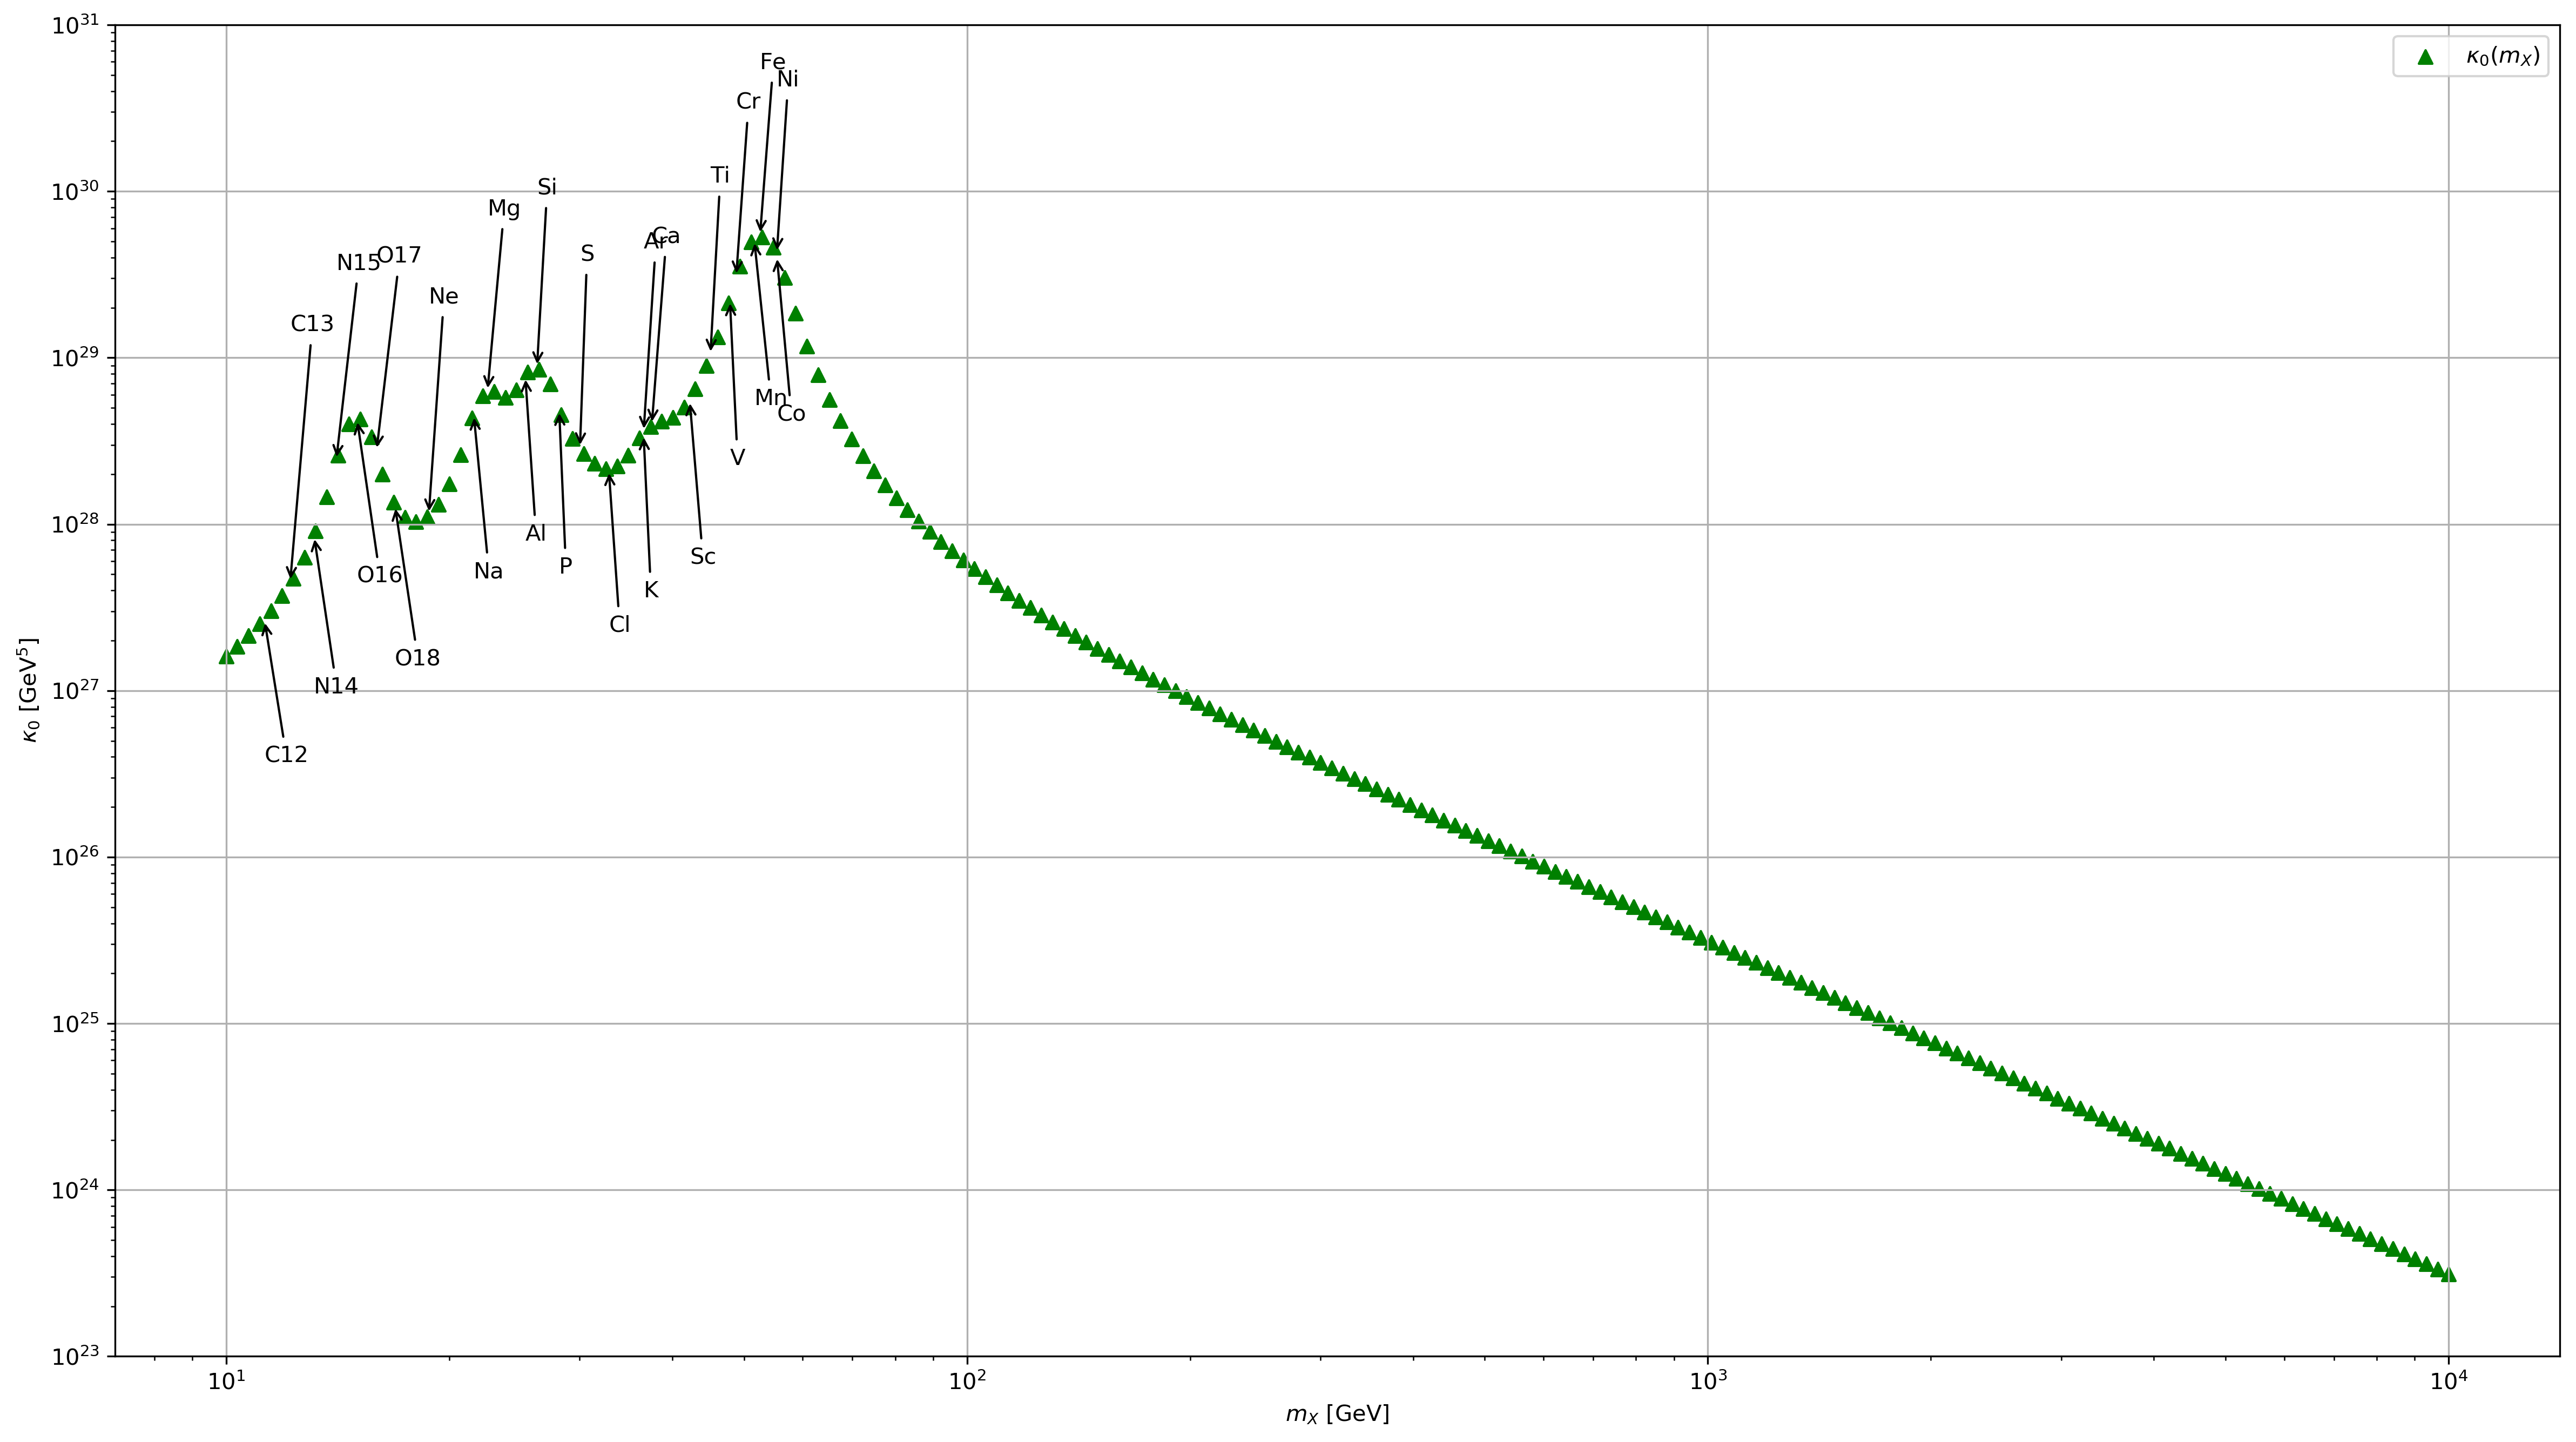

In [84]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)

ax.scatter(mx, kappa, label = '$\\kappa_0(m_X)$', marker = '^',
           color = 'g')
for i, elementMass in enumerate(elementsMass) :
    mass = float(elementMass[1])
    y = kapa(mass)
    if i%2 == 0 :
        
        offsetY = 10**26+y/10
    else :
        
        offsetY = 10**29 + y*10 
        
    ax.annotate(elementMass[0], (mass, y), xytext = (mass, offsetY), arrowprops = dict(arrowstyle = '->'))

ax.legend()
ax.grid()
ax.set_ylim(1e23, 1e31)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\kappa_0$ [GeV$^{5}$]')
ax.set_xlabel('$m_X$ [GeV]')

fig.tight_layout()

The shape of $\kappa_0(m_X)$ is as we expect it to be. We can now compute different $C_{Cap}(m_X)$ curves for different values of $(\varepsilon, m_A)$ quickly, as all the heavy computing bit has been done in computing $\kappa_0(m_X)$. Let's try it out for $m_A = 0.1$ GeV and $\varepsilon = 10^{-8}$.

In [86]:
alpha_X = 0.035
alpha = 1/137
epsilon = 1e-8
m_A = 0.1
Cap = np.empty_like(mx)

It might be interesting to try using numba to vectorize the cCapQuick function, so that we can compute $C_{Cap}$ for the whole $m_X$ range at once, instead of having to loop through all $m_X$ values.

In [92]:
for i, m in enumerate(mx) :
    Cap[i] = cCapQuick(m, m_A, epsilon, alpha_X, kappa[i])

We define a new function so that we can place our elements label, the same way we did for $\kappa_0$

In [94]:
cap = interpolate.interp1d(mx, Cap, kind = 'cubic')

And plot it !

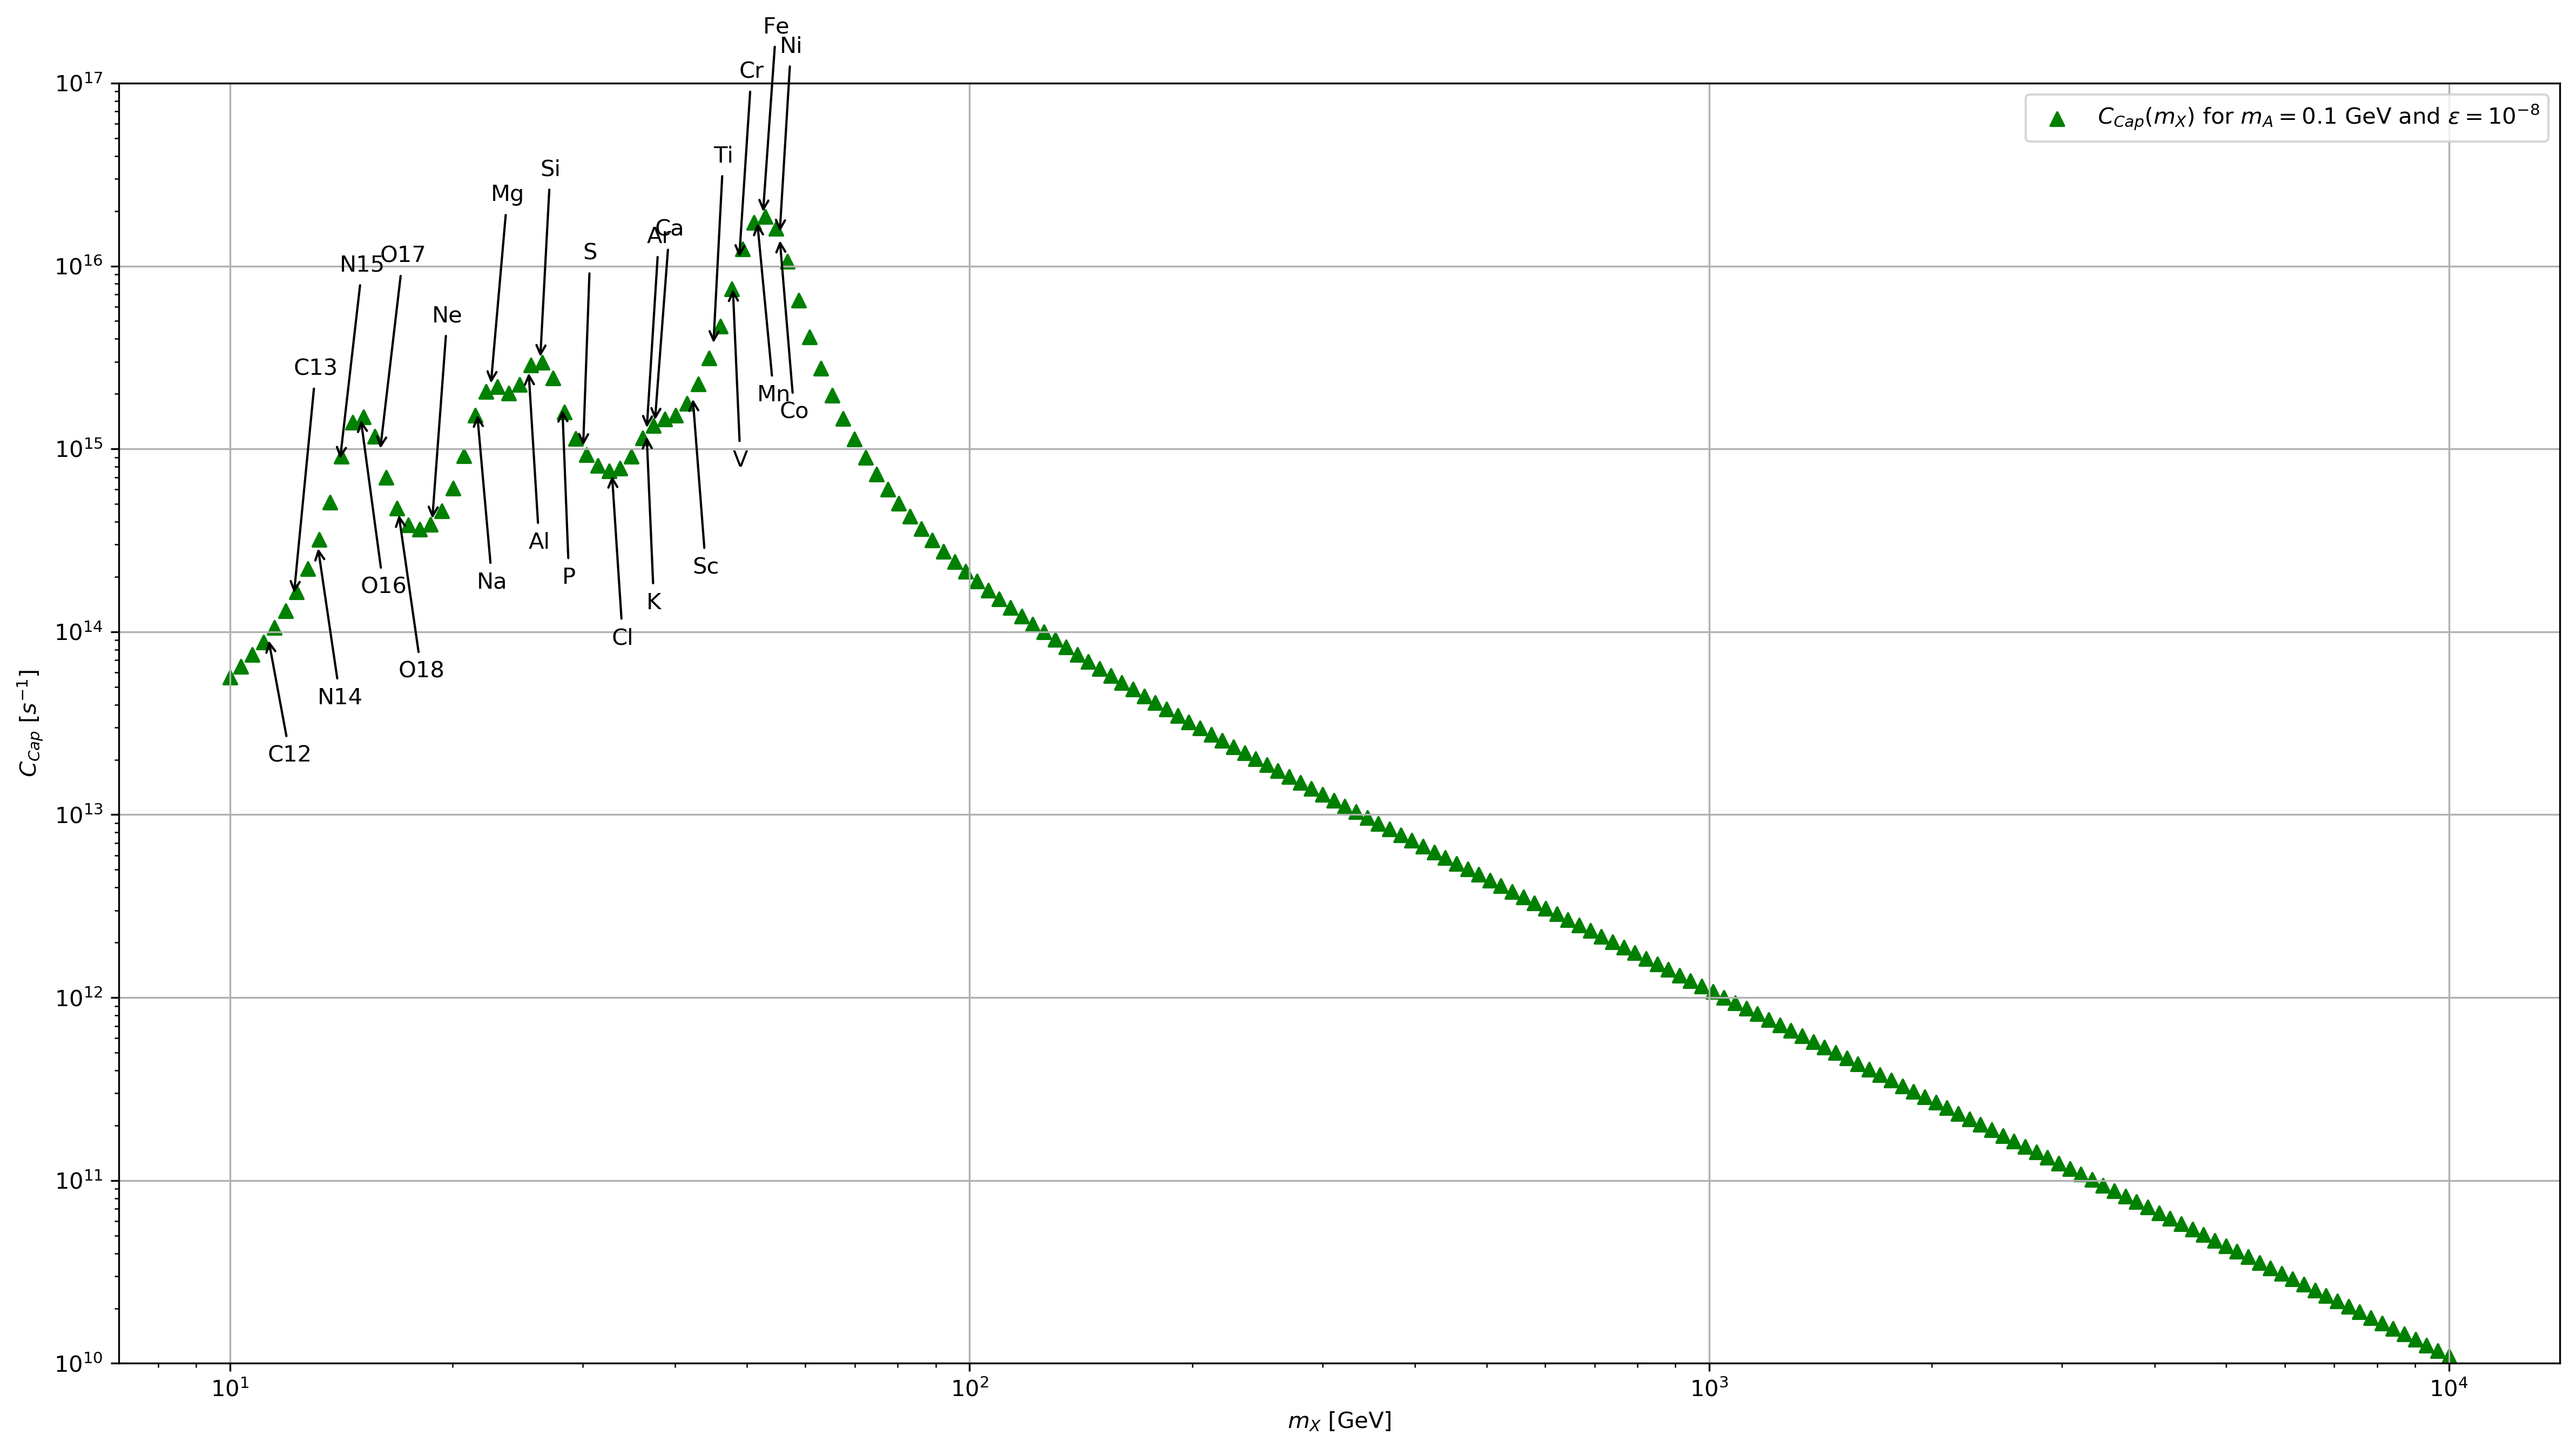

In [101]:
fig, ax = plt.subplots(1, 1, figsize = (16, 9), dpi = 300)

ax.scatter(mx, Cap, label = '$C_{Cap}(m_X)$ for $m_A = 0.1$ GeV and $\\varepsilon = 10^{-8}$', marker = '^',
           color = 'g')
for i, elementMass in enumerate(elementsMass) :
    mass = float(elementMass[1])
    y = cap(mass)
    if i%2 == 0 :
        
        offsetY = 10**13+y/10
    else :
        
        offsetY = 10**15 + y*10 
        
    ax.annotate(elementMass[0], (mass, y), xytext = (mass, offsetY), arrowprops = dict(arrowstyle = '->'))

ax.legend()
ax.grid()
ax.set_ylim(1e10, 1e17)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$C_{Cap}$ [$s^{-1}$]')
ax.set_xlabel('$m_X$ [GeV]')

fig.tight_layout()

In [102]:
fig.savefig('capture_rate')